# **PACKAGES**

In [2]:
pip install nltk pandas scikit-learn torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 658.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# **DATASET CLEANSING**

In [3]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text, dataset='IMDb'):
    # Check if text is not NaN and is a string
    if isinstance(text, str):
        text = re.sub(r'http\S+', '', text)  # Remove HTTP tags
        text = re.sub(r'[^\w\s]', '', text)  # Remove symbols
        words = text.split()
        words = [word.lower() for word in words if word.lower() not in stop_words]  # Remove stop words and convert to lower case
        if dataset == 'IMDb':
            words = [word for word in words if word != 'br']  # Remove 'br' specific to IMDb
        return ' '.join(words)
    else:
        return ''  # Return empty string for NaN or non-string values

# Load datasets
imdb_data = pd.read_csv('/kaggle/input/small-gnndata/4000 imdb.csv', encoding='utf-8')
twitter_data = pd.read_csv('/kaggle/input/twitter/Sentiment Analysis Dataset.csv', encoding='latin1')

# Clean datasets
imdb_data['review'] = imdb_data['review'].apply(lambda x: clean_text(x, 'IMDb'))
twitter_data['SentimentText'] = twitter_data['SentimentText'].apply(lambda x: clean_text(x, 'Twitter'))

# Save cleaned datasets to CSV
imdb_data.to_csv('cleaned_4000 imdb.csv', index=False)
twitter_data.to_csv('cleaned_5000 twitter.csv', index=False)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **WITHOUT TUNNING(5 layers ,256 hidden channels )**

/tmp/ipykernel_34/1041003018.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)


Epoch 1, Loss: 0.6930246353149414
Epoch 2, Loss: 0.6927680373191833
Epoch 3, Loss: 0.6924378275871277
Epoch 4, Loss: 0.692050039768219
Epoch 5, Loss: 0.6919602751731873
Epoch 6, Loss: 0.6916140913963318
Epoch 7, Loss: 0.6911213397979736
Epoch 8, Loss: 0.690733790397644
Epoch 9, Loss: 0.6902123093605042
Epoch 10, Loss: 0.6893177032470703
Epoch 11, Loss: 0.6881105899810791
Epoch 12, Loss: 0.6863009929656982
Epoch 13, Loss: 0.6841505169868469
Epoch 14, Loss: 0.6809095144271851
Epoch 15, Loss: 0.676642119884491
Epoch 16, Loss: 0.6704077124595642
Epoch 17, Loss: 0.6633274555206299
Epoch 18, Loss: 0.6533820629119873
Epoch 19, Loss: 0.6423346400260925
Epoch 20, Loss: 0.629294753074646
Epoch 21, Loss: 0.6167187690734863
Epoch 22, Loss: 0.6034253239631653
Epoch 23, Loss: 0.5926628708839417
Epoch 24, Loss: 0.5861116647720337
Epoch 25, Loss: 0.5848071575164795
Epoch 26, Loss: 0.5747287273406982
Epoch 27, Loss: 0.569424569606781
Epoch 28, Loss: 0.563506007194519
Epoch 29, Loss: 0.5581729412078857


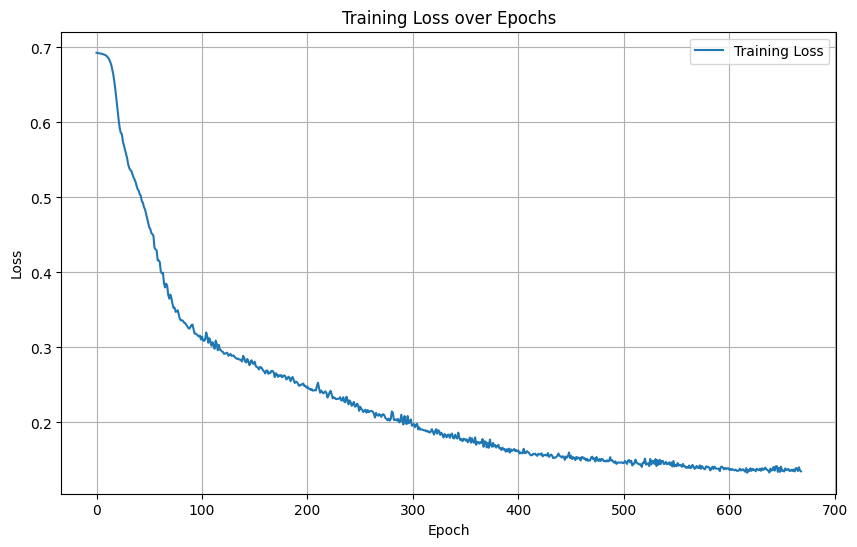

IMDb Test Accuracy: 0.5069, Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000
Twitter Train Accuracy: 0.9474, Precision: 0.9403, Recall: 0.9609, F1 Score: 0.9505


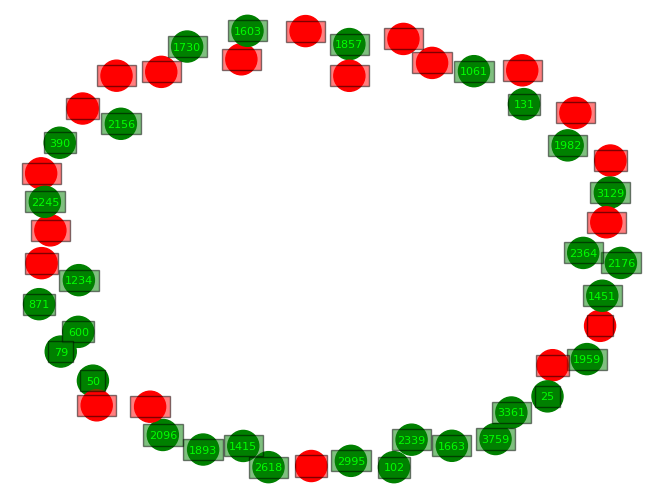

In [14]:
import pandas as pd
import torch
import scipy.sparse as sp
import numpy as np
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import networkx as nx

# Load IMDb Dataset
try:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
except UnicodeDecodeError:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='latin1')

# Ensure that we have the correct sentiment values only
imdb_data = imdb_data[imdb_data['sentiment'].isin(['positive', 'negative'])]

X_imdb = imdb_data['review']
y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)

# Load Twitter Dataset
try:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='utf-8')
except UnicodeDecodeError:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='latin1')

# Ensure the Twitter dataset is not empty and drop NaNs
twitter_data = twitter_data.dropna(subset=['SentimentText'])

# Sample 20,000 rows from Twitter dataset
twitter_data_sampled = twitter_data.sample(n=20000, random_state=42)
X_twitter = twitter_data_sampled['SentimentText']
y_twitter = twitter_data_sampled['Sentiment'].astype(int)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_imdb_tfidf = vectorizer.fit_transform(X_imdb)
X_twitter_tfidf = vectorizer.transform(X_twitter)

# Convert to Sparse Matrices
adj_imdb = X_imdb_tfidf.tocoo()
adj_twitter = X_twitter_tfidf.tocoo()

# Convert to PyTorch Geometric format
edge_index_imdb, edge_attr_imdb = from_scipy_sparse_matrix(adj_imdb)
edge_index_twitter, edge_attr_twitter = from_scipy_sparse_matrix(adj_twitter)

x_imdb = torch.tensor(adj_imdb.toarray(), dtype=torch.float)
x_twitter = torch.tensor(adj_twitter.toarray(), dtype=torch.float)

# Ensure edge indices are within bounds
max_node_imdb = x_imdb.size(0) - 1
max_node_twitter = x_twitter.size(0) - 1

edge_index_imdb = edge_index_imdb[:, (edge_index_imdb[0] <= max_node_imdb) & (edge_index_imdb[1] <= max_node_imdb)]
edge_index_twitter = edge_index_twitter[:, (edge_index_twitter[0] <= max_node_twitter) & (edge_index_twitter[1] <= max_node_twitter)]

# Define Data objects for PyTorch Geometric
data_twitter = Data(x=x_twitter, edge_index=edge_index_twitter, edge_attr=edge_attr_twitter, y=torch.tensor(y_twitter.values, dtype=torch.long))
data_imdb = Data(x=x_imdb, edge_index=edge_index_imdb, edge_attr=edge_attr_imdb, y=torch.tensor(y_imdb.values, dtype=torch.long))

# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_twitter = data_twitter.to(device)
data_imdb = data_imdb.to(device)

# GNN Model Definition with 5 Layers
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv5(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize model and optimizer
model = GNN(num_features=x_twitter.shape[1], hidden_channels=256, num_classes=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
model.train()

# Lists to store loss values
loss_values = []

best_loss = float('inf')
best_model = None
patience = 50
current_patience = 0

for epoch in range(2000):
    optimizer.zero_grad()
    out = model(data_twitter)
    loss = F.nll_loss(out, data_twitter.y)
    loss.backward()
    optimizer.step()

    # Store loss value
    loss_values.append(loss.item())

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Check if validation loss has improved
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model = model.state_dict()
        current_patience = 0
    else:
        current_patience += 1
        if current_patience > patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

# Save the best model state dict
if best_model:
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), "best_model.pth")
    print("Best model saved as 'best_model.pth'.")

# Plotting the loss values across epochs
plt.figure(figsize=(10, 6))
plt.plot(range(len(loss_values)), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Clear GPU memory before evaluation
torch.cuda.empty_cache()

# Load the best model state dict for evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluation on IMDb Data (Test)
with torch.no_grad():
    data_imdb = data_imdb.to('cpu')
    model = model.to('cpu')
    out = model(data_imdb)
    _, pred = out.max(dim=1)
    y_true = data_imdb.y.cpu().numpy()
    y_pred = pred.cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)
    print(f'IMDb Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Clear GPU memory again
torch.cuda.empty_cache()

# Evaluation on Twitter Data (Train)
with torch.no_grad():
    data_twitter = data_twitter.to('cpu')
    model = model.to('cpu')
    out = model(data_twitter)
    _, pred = out.max(dim=1)
    y_true = data_twitter.y.cpu().numpy()
    y_pred = pred.cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Twitter Train Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Function to add node attributes
def add_node_attributes(G, node_id, word, label, classification):
    color = 'green' if classification == 'positive' else 'red'
    text_color = '#FFFFFF'
    if color == 'green':
        text_color = '#00FF00'
    elif color == 'red':
        text_color = '#FF0000'

    G.add_node(node_id, word=word, label=label, classification=classification, color=color, text_color=text_color)

# Function to add edge attributes
def add_edge_attributes(G, edge_index, edge_id):
    src, dst = edge_index[:, edge_id]
    G.add_edge(src, dst, color='blue')

# Function to sample and save graph
def sample_graph(data, edge_index, num_samples, words, labels):
    valid_node_ids = np.arange(len(words))
    sampled_nodes = np.random.choice(valid_node_ids, num_samples, replace=False)
    G = nx.Graph()

    for node_id in sampled_nodes:
        review_label = labels[node_id]
        add_node_attributes(G, node_id, words[node_id], node_id, 'positive' if review_label == 1 else 'negative')

    sampled_edges = []
    for edge_id in range(edge_index.size(1)):
        src, dst = edge_index[:, edge_id]
        if src in sampled_nodes and dst in sampled_nodes:
            sampled_edges.append(edge_id)

    for edge_id in sampled_edges:
        add_edge_attributes(G, edge_index, edge_id)

    pos = nx.spring_layout(G, seed=42)
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    edge_colors = [G.edges[edge]['color'] for edge in G.edges()]
    nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors, edge_color=edge_colors)
    for node_id, (x, y) in pos.items():
        plt.text(x, y, s=G.nodes[node_id]['word'], bbox=dict(facecolor=G.nodes[node_id]['color'], alpha=0.5), verticalalignment='center', horizontalalignment='center', fontsize=8, color=G.nodes[node_id]['text_color'])
    plt.show()

# Sample and plot graph
sample_graph(data_imdb, edge_index_imdb, num_samples=50, words=X_imdb.index, labels=y_imdb.values)


# **POSTIVE AND NEAGTIVE WORDS IN DATASETS**

/tmp/ipykernel_34/2309435356.py:98: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)


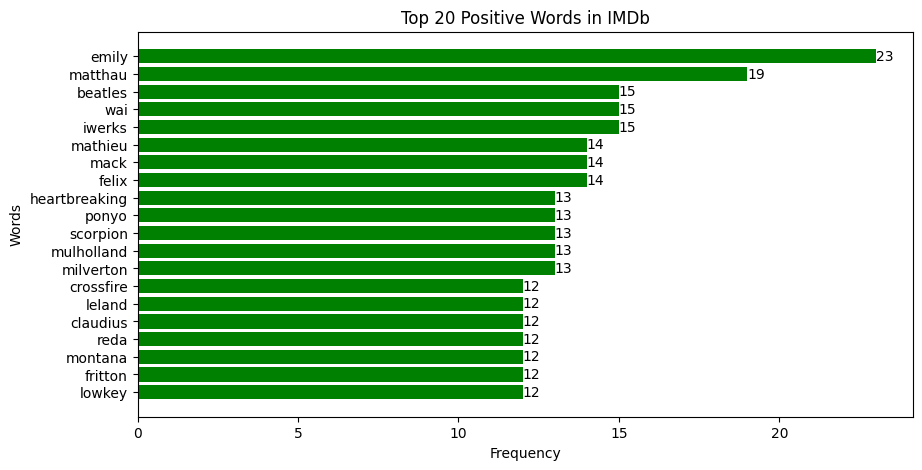

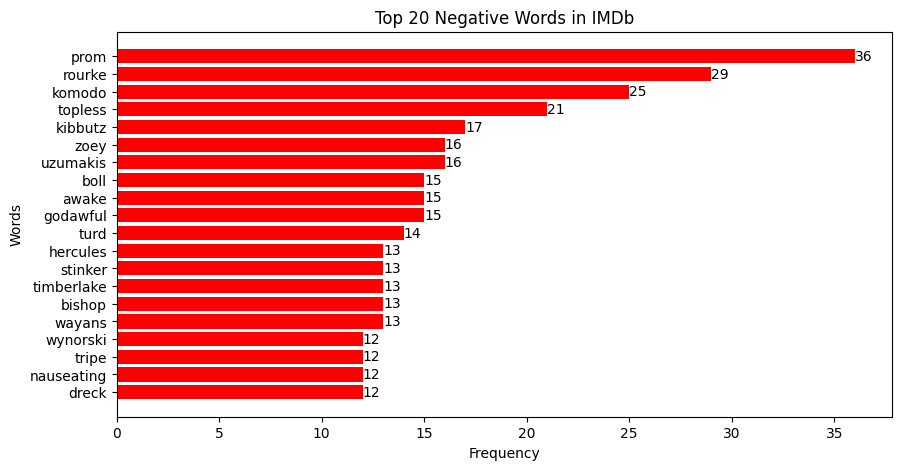

Total words in IMDb dataset: 41935
Total positive words in IMDb dataset: 22303
Total negative words in IMDb dataset: 19632


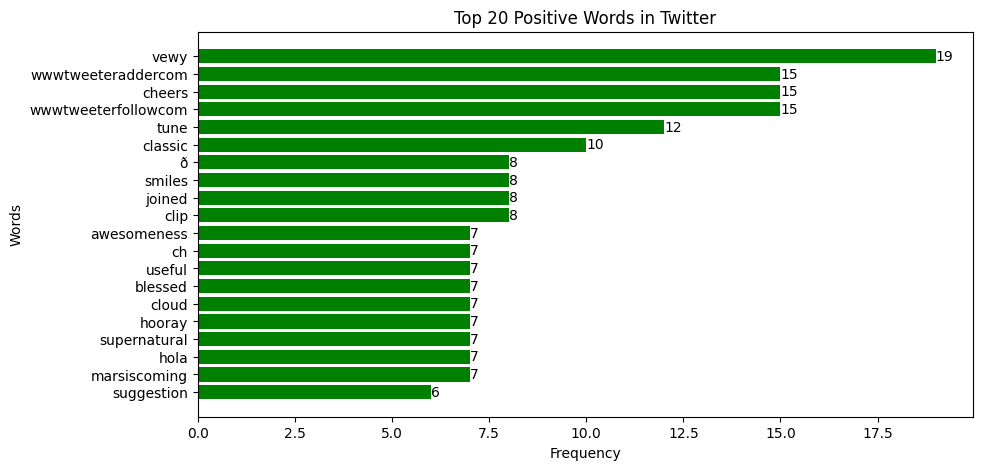

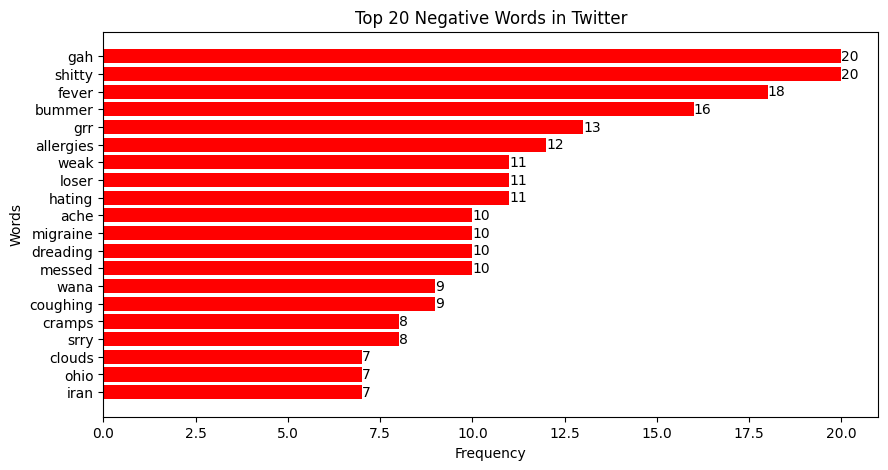

Total words in Twitter dataset: 28809
Total positive words in Twitter dataset: 16107
Total negative words in Twitter dataset: 12702


In [17]:
import matplotlib.pyplot as plt
from collections import Counter
import re
import pandas as pd

# Function to clean text and remove numbers or specific unwanted words
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [word.lower() for word in words if word.isalpha() and word != 'wwwtweetaddercom']  # Convert to lower case, remove numbers, and specific words
    return words

# Count word frequencies in each dataset
def count_word_frequencies(X, y):
    pos_words = Counter()
    neg_words = Counter()

    for review, sentiment in zip(X, y):
        words = clean_text(review)
        if sentiment == 1:
            pos_words.update(words)
        else:
            neg_words.update(words)

    return pos_words, neg_words

# Remove common words between positive and negative sentiment counts
def filter_common_words(pos_words, neg_words):
    common_words = set(pos_words.keys()) & set(neg_words.keys())
    for word in common_words:
        if word in pos_words:
            del pos_words[word]
        if word in neg_words:
            del neg_words[word]
    return pos_words, neg_words

# Plot word distributions
def plot_word_distributions(pos_words, neg_words, dataset_name):
    total_pos_words = sum(pos_words.values())
    total_neg_words = sum(neg_words.values())
    total_words = total_pos_words + total_neg_words

    # Remove 'wwwtweetaddercom' from positive words if present
    if 'wwwtweetaddercom' in pos_words:
        del pos_words['wwwtweetaddercom']

    # Get the most common words
    pos_common = pos_words.most_common(20)
    neg_common = neg_words.most_common(20)

    # Plot positive words
    pos_words_list, pos_freqs = zip(*pos_common)
    plt.figure(figsize=(10, 5))
    bars = plt.barh(pos_words_list, pos_freqs, color='green')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 20 Positive Words in {dataset_name}')
    plt.gca().invert_yaxis()

    # Adding frequency numbers on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, str(width), ha='left', va='center')

    plt.show()

    # Plot negative words
    neg_words_list, neg_freqs = zip(*neg_common)
    plt.figure(figsize=(10, 5))
    bars = plt.barh(neg_words_list, neg_freqs, color='red')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 20 Negative Words in {dataset_name}')
    plt.gca().invert_yaxis()

    # Adding frequency numbers on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height() / 2, str(width), ha='left', va='center')

    plt.show()

    # Print total word counts
    print(f'Total words in {dataset_name} dataset: {total_words}')
    print(f'Total positive words in {dataset_name} dataset: {total_pos_words}')
    print(f'Total negative words in {dataset_name} dataset: {total_neg_words}')

# Load IMDb Dataset
try:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
except UnicodeDecodeError:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='latin1')

# Ensure that we have the correct sentiment values only
imdb_data = imdb_data[imdb_data['sentiment'].isin(['positive', 'negative'])]

X_imdb = imdb_data['review']
y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)

# Load Twitter Dataset
try:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='utf-8')
except UnicodeDecodeError:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='latin1')

# Ensure the Twitter dataset is not empty and drop NaNs
twitter_data = twitter_data.dropna(subset=['SentimentText'])

# Sample 20,000 rows from Twitter dataset
twitter_data_sampled = twitter_data.sample(n=20000, random_state=42)
X_twitter = twitter_data_sampled['SentimentText']
y_twitter = twitter_data_sampled['Sentiment'].astype(int)

# Count word frequencies for IMDb dataset
pos_words_imdb, neg_words_imdb = count_word_frequencies(X_imdb, y_imdb)

# Count word frequencies for Twitter dataset
pos_words_twitter, neg_words_twitter = count_word_frequencies(X_twitter, y_twitter)

# Remove common words from both positive and negative word counts
pos_words_imdb, neg_words_imdb = filter_common_words(pos_words_imdb, neg_words_imdb)
pos_words_twitter, neg_words_twitter = filter_common_words(pos_words_twitter, neg_words_twitter)

# Plot word distributions for IMDb dataset
plot_word_distributions(pos_words_imdb, neg_words_imdb, 'IMDb')

# Plot word distributions for Twitter dataset
plot_word_distributions(pos_words_twitter, neg_words_twitter, 'Twitter')


# **CONFUSION MATRIX OF THE DATASET**

/tmp/ipykernel_34/2116271831.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)


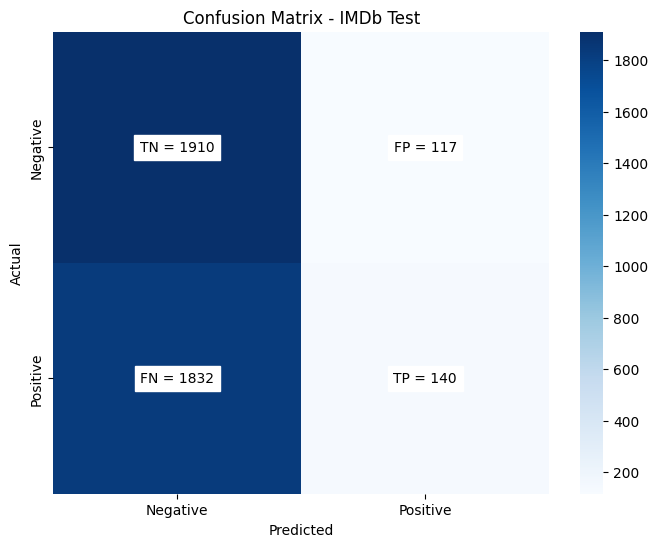

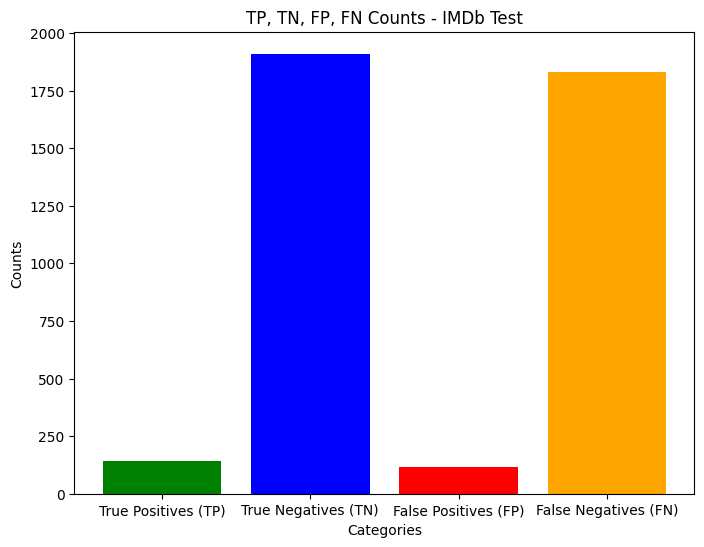

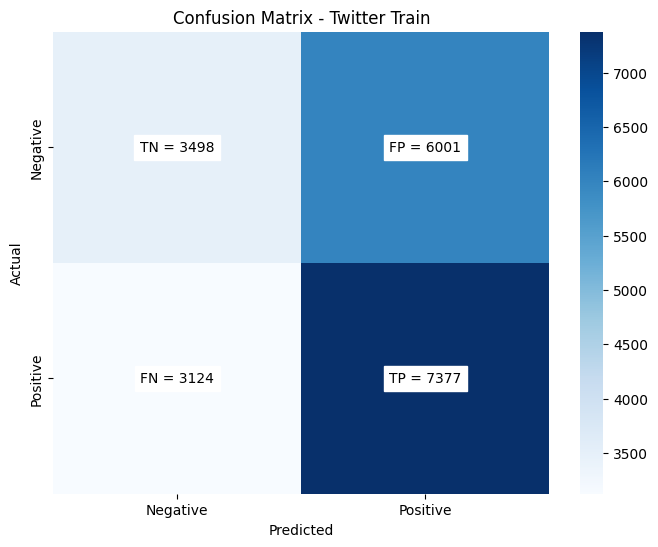

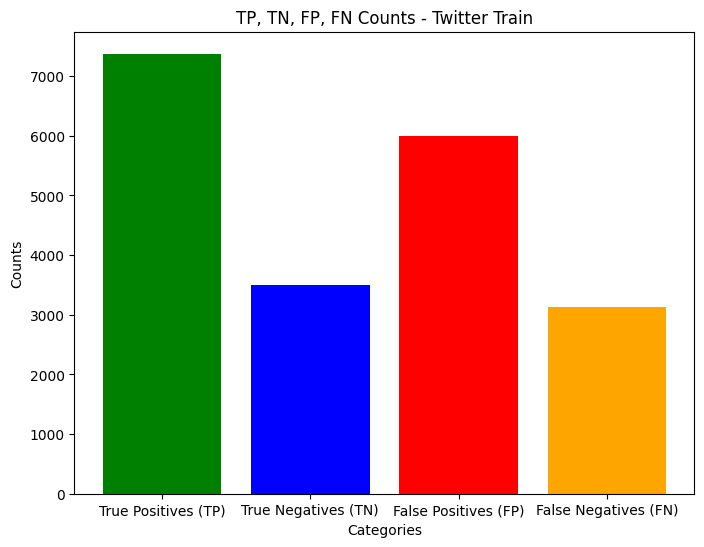

In [20]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix

# Define your GNN model here (assuming it's already defined)
# class GNN(torch.nn.Module):
#     ...

# Initialize the model, load state dict, and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 # Adjust as needed
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load IMDb Dataset
try:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
except UnicodeDecodeError:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='latin1')

# Ensure that we have the correct sentiment values only
imdb_data = imdb_data[imdb_data['sentiment'].isin(['positive', 'negative'])]

X_imdb = imdb_data['review']
y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)

# Load Twitter Dataset
try:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='utf-8')
except UnicodeDecodeError:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='latin1')

# Ensure the Twitter dataset is not empty and drop NaNs
twitter_data = twitter_data.dropna(subset=['SentimentText'])

# Sample 20,000 rows from Twitter dataset
twitter_data_sampled = twitter_data.sample(n=20000, random_state=42)
X_twitter = twitter_data_sampled['SentimentText']
y_twitter = twitter_data_sampled['Sentiment'].astype(int)

# TF-IDF Vectorization with stop words removal
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_imdb_tfidf = vectorizer.fit_transform(X_imdb)
X_twitter_tfidf = vectorizer.transform(X_twitter)

# Convert to Sparse Matrices
adj_imdb = X_imdb_tfidf.tocoo()
adj_twitter = X_twitter_tfidf.tocoo()

# Preprocess input for PyTorch Geometric
def preprocess_input(tfidf_matrix, labels):
    adj = tfidf_matrix.tocoo()
    x = torch.tensor(adj.toarray(), dtype=torch.float)
    edge_index, edge_attr = from_scipy_sparse_matrix(adj)

    # Ensure edge indices are within bounds
    max_node = x.size(0) - 1
    edge_index = edge_index[:, (edge_index[0] <= max_node) & (edge_index[1] <= max_node)]

    # Create Data object and add labels
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    data.y = torch.tensor(labels.values, dtype=torch.long)  # Ensure labels are added and properly cast to long
    
    return data

data_imdb = preprocess_input(X_imdb_tfidf, y_imdb)
data_twitter = preprocess_input(X_twitter_tfidf, y_twitter)

# Function to plot confusion matrix with TP, TN, FP, FN
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {dataset_name}')

    # Add text for TP, TN, FP, FN
    plt.text(0.5, 0.5, f'TN = {tn}', ha='center', va='center', color='black', backgroundcolor='white')
    plt.text(1.5, 0.5, f'FP = {fp}', ha='center', va='center', color='black', backgroundcolor='white')
    plt.text(0.5, 1.5, f'FN = {fn}', ha='center', va='center', color='black', backgroundcolor='white')
    plt.text(1.5, 1.5, f'TP = {tp}', ha='center', va='center', color='black', backgroundcolor='white')

    plt.show()

    # Plot TP, TN, FP, FN
    plt.figure(figsize=(8, 6))
    labels = ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)']
    values = [tp, tn, fp, fn]
    plt.bar(labels, values, color=['green', 'blue', 'red', 'orange'])
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title(f'TP, TN, FP, FN Counts - {dataset_name}')
    plt.show()

# Evaluation and plotting confusion matrix for IMDb Data (Test)
with torch.no_grad():
    out_imdb = model(data_imdb.to(device))
    _, pred_imdb = out_imdb.max(dim=1)
    y_true_imdb = data_imdb.y.cpu().numpy()
    y_pred_imdb = pred_imdb.cpu().numpy()
    plot_confusion_matrix(y_true_imdb, y_pred_imdb, 'IMDb Test')

# Evaluation and plotting confusion matrix for Twitter Data (Train)
with torch.no_grad():
    out_twitter = model(data_twitter.to(device))
    _, pred_twitter = out_twitter.max(dim=1)
    y_true_twitter = data_twitter.y.cpu().numpy()
    y_pred_twitter = pred_twitter.cpu().numpy()
    plot_confusion_matrix(y_true_twitter, y_pred_twitter, 'Twitter Train')


# **TEST FOR MODEL WITHOUT TUNNING WITH ONLINE REVIEW**

In [21]:
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.utils import from_scipy_sparse_matrix

# Define the GNN Model with 5 Layers
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv5(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_features=5000, hidden_channels=256, num_classes=2)
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load the vectorizer used during training
vectorizer = TfidfVectorizer(max_features=5000)
imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
X_imdb = imdb_data['review']
vectorizer.fit(X_imdb)

def preprocess_input(paragraph):
    # Preprocess the input paragraph
    input_tfidf = vectorizer.transform([paragraph])
    adj_input = input_tfidf.tocoo()
    x_input = torch.tensor(adj_input.toarray(), dtype=torch.float)

    # Convert to PyTorch Geometric format
    edge_index_input, edge_attr_input = from_scipy_sparse_matrix(adj_input)
    
    # Ensure edge indices are within bounds
    max_node_input = x_input.size(0) - 1
    edge_index_input = edge_index_input[:, (edge_index_input[0] <= max_node_input) & (edge_index_input[1] <= max_node_input)]

    # Define Data object for PyTorch Geometric
    data_input = Data(x=x_input, edge_index=edge_index_input, edge_attr=edge_attr_input)
    return data_input

def predict(paragraph):
    data_input = preprocess_input(paragraph)
    data_input = data_input.to(device)
    with torch.no_grad():
        out = model(data_input)
        probabilities = torch.exp(out)  # Convert log-softmax back to probabilities
        _, pred = probabilities.max(dim=1)
        confidence = probabilities[0, pred.item()].item()  # Get the probability of the predicted class
        sentiment = "Positive" if pred.item() == 1 else "Negative"
        return sentiment, confidence

# Example input
paragraph1 = (
    "Literally one of the worst superhero movies I have ever seen. From the advertisements, I knew this movie "
    "wasn't going to be great but still, it surprised me how bad and boring it was. Everything about the direction, "
    "writing, characters, technical aspects, and designs are really awful. The writing is poor as there are many "
    "concepts, ideas and aspects that are messy and bland. The messy script creates poor dialogue from the cast "
    "and the characters are not interesting. The special effects looked even worse than the marketing and all of "
    "the performances were pretty bad. I honestly do feel bad for Dakota Johnson cause she is a good actress but "
    "she deserves to have better roles than this. It can be said for the same for the rest of the cast members."
)

paragraph2 = (
    "Hugh Jackman is the perfect Wolverine. What a fun movie. I like the dialogue and clever quips with f bombs "
    "sprinkled in. It's definitely not taking itself too seriously. There is tons of fun cameos I didn't expect! "
    "I normally watch spoiler videos ahead of time, but I didn't on this occasion and I'm glad I didn't because "
    "there was some oh snap moments! It's a very good action-packed fun film. The breaking the Fox jokes and "
    "speaking to the camera jokes are too funny. I can definitely see more sequels for these two on the horizon. "
    "They are promoting this movie hard I just watched these two on Hot Ones eating chicken wings. They make a "
    "dynamic duo. Until your 90 Wolverine ...until your 90 lol."
)

# Prediction for paragraph1
prediction1, confidence1 = predict(paragraph1)
print(f'Paragraph: {paragraph1}\nSentiment: {prediction1}, Confidence: {confidence1:.2f}\n')

# Prediction for paragraph2
prediction2, confidence2 = predict(paragraph2)
print(f'Paragraph: {paragraph2}\nSentiment: {prediction2}, Confidence: {confidence2:.2f}\n')


Paragraph: Literally one of the worst superhero movies I have ever seen. From the advertisements, I knew this movie wasn't going to be great but still, it surprised me how bad and boring it was. Everything about the direction, writing, characters, technical aspects, and designs are really awful. The writing is poor as there are many concepts, ideas and aspects that are messy and bland. The messy script creates poor dialogue from the cast and the characters are not interesting. The special effects looked even worse than the marketing and all of the performances were pretty bad. I honestly do feel bad for Dakota Johnson cause she is a good actress but she deserves to have better roles than this. It can be said for the same for the rest of the cast members.
Sentiment: Negative, Confidence: 1.00

Paragraph: Hugh Jackman is the perfect Wolverine. What a fun movie. I like the dialogue and clever quips with f bombs sprinkled in. It's definitely not taking itself too seriously. There is tons o

# **TEST FOR MODEL WITHOUT TUNNING WITH OWN REVIEW**

In [22]:
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.utils import from_scipy_sparse_matrix

# Define the GNN Model with 5 Layers
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv5(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(num_features=5000, hidden_channels=256, num_classes=2)
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load the vectorizer used during training
vectorizer = TfidfVectorizer(max_features=5000)
imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
X_imdb = imdb_data['review']
vectorizer.fit(X_imdb)

def preprocess_input(paragraph):
    # Preprocess the input paragraph
    input_tfidf = vectorizer.transform([paragraph])
    adj_input = input_tfidf.tocoo()
    x_input = torch.tensor(adj_input.toarray(), dtype=torch.float)

    # Convert to PyTorch Geometric format
    edge_index_input, edge_attr_input = from_scipy_sparse_matrix(adj_input)
    
    # Ensure edge indices are within bounds
    max_node_input = x_input.size(0) - 1
    edge_index_input = edge_index_input[:, (edge_index_input[0] <= max_node_input) & (edge_index_input[1] <= max_node_input)]

    # Define Data object for PyTorch Geometric
    data_input = Data(x=x_input, edge_index=edge_index_input, edge_attr=edge_attr_input)
    return data_input

def predict(paragraph):
    data_input = preprocess_input(paragraph)
    data_input = data_input.to(device)
    with torch.no_grad():
        out = model(data_input)
        probabilities = torch.exp(out)  # Convert log-softmax back to probabilities
        _, pred = probabilities.max(dim=1)
        confidence = probabilities[0, pred.item()].item()  # Get the probability of the predicted class
        sentiment = "Positive" if pred.item() == 1 else "Negative"
        return sentiment, confidence

# Example input
paragraph1 = (
    "I have watched demonty colony 2 the story was good part 1 connection to part 2 is good nice horror thriller movie"
)

paragraph2 = (
    "thangalaan movie is slow and not steady screenplay makes it bad flim and some part of flim became boring"
)

# Prediction for paragraph1
prediction1, confidence1 = predict(paragraph1)
print(f'Paragraph: {paragraph1}\nSentiment: {prediction1}, Confidence: {confidence1:.2f}\n')

# Prediction for paragraph2
prediction2, confidence2 = predict(paragraph2)
print(f'Paragraph: {paragraph2}\nSentiment: {prediction2}, Confidence: {confidence2:.2f}\n')


Paragraph: I have watched demonty colony 2 the story was good part 1 connection to part 2 is good nice horror thriller movie
Sentiment: Positive, Confidence: 0.98

Paragraph: thangalaan movie is slow and not steady screenplay makes it bad flim and some part of flim became boring
Sentiment: Negative, Confidence: 0.90



# **HYPERPARAMETER TUNNING CODE**

/tmp/ipykernel_34/1428451846.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)


Early stopping at epoch 621
Trial 1, Layers: 4, Hidden Channels: 512, LR: 0.005, Weight Decay: 5e-05, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Score: 0.6605
Early stopping at epoch 1015


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial 2, Layers: 5, Hidden Channels: 1024, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping at epoch 400
Trial 3, Layers: 4, Hidden Channels: 64, LR: 0.01, Weight Decay: 0.0005, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 644


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial 4, Layers: 5, Hidden Channels: 128, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping at epoch 691
Trial 5, Layers: 4, Hidden Channels: 128, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.5000, Recall: 0.0005, F1 Score: 0.0010
Early stopping at epoch 1320
Trial 6, Layers: 4, Hidden Channels: 512, LR: 0.001, Weight Decay: 0.0005, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Score: 0.6605
Early stopping at epoch 928
Trial 7, Layers: 5, Hidden Channels: 64, LR: 0.001, Weight Decay: 0.0005, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Score: 0.6605
Early stopping at epoch 1291
Trial 8, Layers: 3, Hidden Channels: 1024, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.5000, Recall: 0.0025, F1 Score: 0.0050
Early stopping at epoch 1193
Trial 9, Layers: 4, Hidden Channels: 512, LR: 0.001, Weight Decay: 0.0005, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Scor

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial 12, Layers: 5, Hidden Channels: 128, LR: 0.005, Weight Decay: 0.0005, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping at epoch 546
Trial 13, Layers: 2, Hidden Channels: 512, LR: 0.01, Weight Decay: 0.0005, Accuracy: 0.5099, Precision: 0.5036, Recall: 0.4305, F1 Score: 0.4642
Early stopping at epoch 862
Trial 14, Layers: 2, Hidden Channels: 64, LR: 0.005, Weight Decay: 0.0005, Accuracy: 0.5119, Precision: 0.5030, Recall: 0.8580, F1 Score: 0.6342
Early stopping at epoch 537
Trial 15, Layers: 3, Hidden Channels: 1024, LR: 0.01, Weight Decay: 0.0005, Accuracy: 0.4889, Precision: 0.4897, Recall: 0.8692, F1 Score: 0.6265
Early stopping at epoch 424
Trial 16, Layers: 4, Hidden Channels: 1024, LR: 0.005, Weight Decay: 5e-05, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Score: 0.6605
Trial 17, Layers: 4, Hidden Channels: 512, LR: 0.001, Weight Decay: 0.0005, Accuracy: 0.4931, Precision: 0.4931, Recall: 1.0000, F1 Score: 0.6605
Early stopping

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial 18, Layers: 5, Hidden Channels: 512, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping at epoch 782


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trial 19, Layers: 5, Hidden Channels: 128, LR: 0.001, Weight Decay: 5e-05, Accuracy: 0.5069, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Early stopping at epoch 621
Trial 20, Layers: 3, Hidden Channels: 128, LR: 0.005, Weight Decay: 5e-05, Accuracy: 0.5024, Precision: 0.4953, Recall: 0.4802, F1 Score: 0.4876
Best Hyperparameters: {'num_layers': 4, 'hidden_channels': 512, 'lr': 0.005, 'weight_decay': 5e-05}


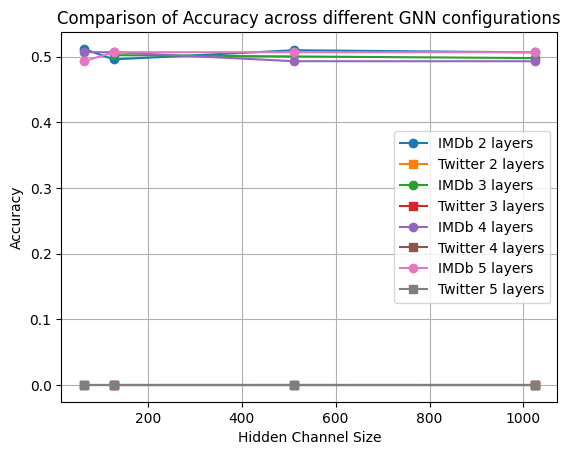

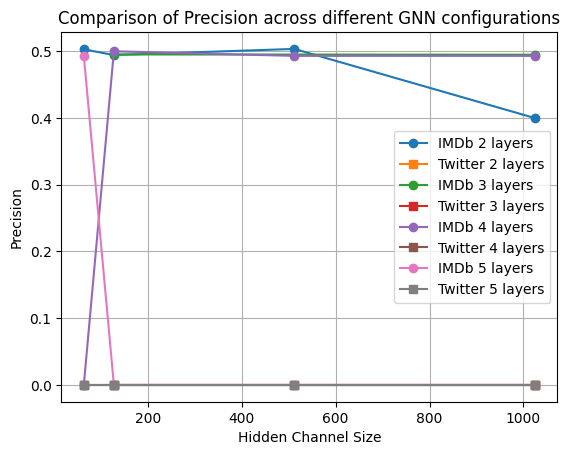

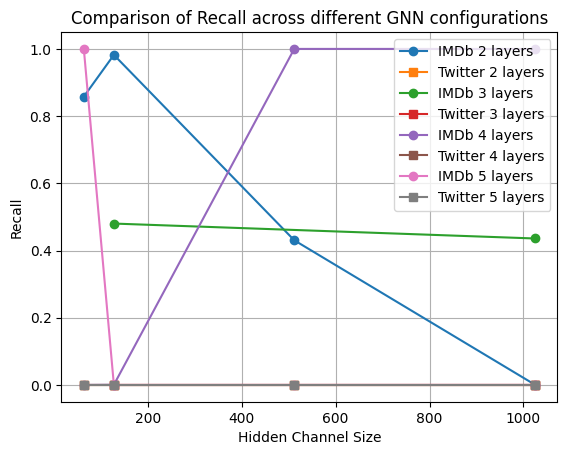

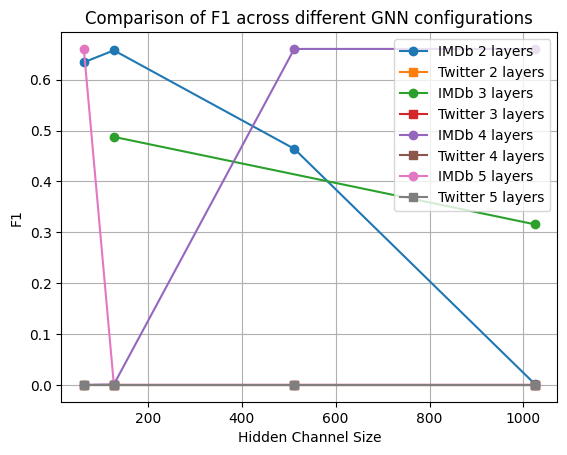

In [24]:
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import numpy as np
import matplotlib.pyplot as plt

# Load IMDb Dataset
try:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
except UnicodeDecodeError:
    imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='latin1')

# Ensure that we have the correct sentiment values only
imdb_data = imdb_data[imdb_data['sentiment'].isin(['positive', 'negative'])]

X_imdb = imdb_data['review']
y_imdb = imdb_data['sentiment'].replace({'positive': 1, 'negative': 0}).astype(int)

# Load Twitter Dataset
try:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='utf-8')
except UnicodeDecodeError:
    twitter_data = pd.read_csv('/kaggle/working/cleaned_5000 twitter.csv', encoding='latin1')

# Ensure the Twitter dataset is not empty and drop NaNs
twitter_data = twitter_data.dropna(subset=['SentimentText'])

# Sample 10,000 rows from Twitter dataset
twitter_data_sampled = twitter_data.sample(n=10000, random_state=42)
X_twitter = twitter_data_sampled['SentimentText']
y_twitter = twitter_data_sampled['Sentiment'].astype(int)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_imdb_tfidf = vectorizer.fit_transform(X_imdb)
X_twitter_tfidf = vectorizer.transform(X_twitter)

# Convert to Sparse Matrices
adj_imdb = X_imdb_tfidf.tocoo()
adj_twitter = X_twitter_tfidf.tocoo()

# Convert to PyTorch Geometric format
edge_index_imdb, edge_attr_imdb = from_scipy_sparse_matrix(adj_imdb)
edge_index_twitter, edge_attr_twitter = from_scipy_sparse_matrix(adj_twitter)

x_imdb = torch.tensor(adj_imdb.toarray(), dtype=torch.float)
x_twitter = torch.tensor(adj_twitter.toarray(), dtype=torch.float)

# Ensure edge indices are within bounds
max_node_imdb = x_imdb.size(0) - 1
max_node_twitter = x_twitter.size(0) - 1

edge_index_imdb = edge_index_imdb[:, (edge_index_imdb[0] <= max_node_imdb) & (edge_index_imdb[1] <= max_node_imdb)]
edge_index_twitter = edge_index_twitter[:, (edge_index_twitter[0] <= max_node_twitter) & (edge_index_twitter[1] <= max_node_twitter)]

# Define Data objects for PyTorch Geometric
data_twitter = Data(x=x_twitter, edge_index=edge_index_twitter, edge_attr=edge_attr_twitter, y=torch.tensor(y_twitter.values, dtype=torch.long))
data_imdb = Data(x=x_imdb, edge_index=edge_index_imdb, edge_attr=edge_attr_imdb, y=torch.tensor(y_imdb.values, dtype=torch.long))

# Move data to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_twitter = data_twitter.to(device)
data_imdb = data_imdb.to(device)

# GNN Model Definition
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Hyperparameter space
num_layers_options = [2, 3, 4, 5]
hidden_channels_options = [64, 128, 512, 1024]
lr_options = [0.001, 0.005, 0.01]
weight_decay_options = [5e-4, 5e-5]

# Random search
num_trials = 20
results = []

for trial in range(num_trials):
    num_layers = random.choice(num_layers_options)
    hidden_channels = random.choice(hidden_channels_options)
    lr = random.choice(lr_options)
    weight_decay = random.choice(weight_decay_options)

    model = GNN(num_features=x_twitter.shape[1], hidden_channels=hidden_channels, num_classes=2, num_layers=num_layers)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()

    best_loss = float('inf')
    best_model = None
    patience = 50
    current_patience = 0

    for epoch in range(1500):  # Increase epochs for longer training
        optimizer.zero_grad()
        out = model(data_twitter)
        loss = F.nll_loss(out, data_twitter.y)
        loss.backward()
        optimizer.step()

        # Check if validation loss has improved
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model = model.state_dict()
            current_patience = 0
        else:
            current_patience += 1
            if current_patience > patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Save the best model state dict
    if best_model:
        model.load_state_dict(best_model)

    # Clear GPU memory before evaluation
    torch.cuda.empty_cache()

    # Evaluation on IMDb Data (Test)
    model.eval()
    with torch.no_grad():
        data_imdb = data_imdb.to('cpu')
        model = model.to('cpu')
        out = model(data_imdb)
        _, pred = out.max(dim=1)
        y_true = data_imdb.y.cpu().numpy()
        y_pred = pred.cpu().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append((num_layers, hidden_channels, lr, weight_decay, accuracy, precision, recall, f1))
        print(f'Trial {trial+1}, Layers: {num_layers}, Hidden Channels: {hidden_channels}, LR: {lr}, Weight Decay: {weight_decay}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

# Save the best model based on F1 score
best_result = max(results, key=lambda x: x[-1])
best_model_params = {
    "num_layers": best_result[0],
    "hidden_channels": best_result[1],
    "lr": best_result[2],
    "weight_decay": best_result[3]
}
print(f'Best Hyperparameters: {best_model_params}')
torch.save(best_model, 'best_gnn_model.pth')

# Function to aggregate results for both IMDb and Twitter datasets
def aggregate_results(results):
    agg_results = {}
    for result in results:
        layers = result[0]
        hidden_channels = result[1]
        if layers not in agg_results:
            agg_results[layers] = {}
        if hidden_channels not in agg_results[layers]:
            agg_results[layers][hidden_channels] = {
                "imdb": {"accuracy": [], "precision": [], "recall": [], "f1": []},
                "twitter": {"accuracy": [], "precision": [], "recall": [], "f1": []}
            }
        agg_results[layers][hidden_channels]["imdb"]["accuracy"].append(result[4])
        agg_results[layers][hidden_channels]["imdb"]["precision"].append(result[5])
        agg_results[layers][hidden_channels]["imdb"]["recall"].append(result[6])
        agg_results[layers][hidden_channels]["imdb"]["f1"].append(result[7])

        # Since Twitter metrics are not calculated, add dummy values (0.0) or implement Twitter metrics as needed
        agg_results[layers][hidden_channels]["twitter"]["accuracy"].append(0.0)
        agg_results[layers][hidden_channels]["twitter"]["precision"].append(0.0)
        agg_results[layers][hidden_channels]["twitter"]["recall"].append(0.0)
        agg_results[layers][hidden_channels]["twitter"]["f1"].append(0.0)
        
    return agg_results

# Function to plot comparison for both IMDb and Twitter
def plot_comparison(agg_results, metric):
    for layers in sorted(agg_results.keys()):
        hidden_channel_sizes = sorted(agg_results[layers].keys())
        imdb_scores = [np.mean(agg_results[layers][hidden_channels]["imdb"][metric]) for hidden_channels in hidden_channel_sizes]
        twitter_scores = [np.mean(agg_results[layers][hidden_channels]["twitter"][metric]) for hidden_channels in hidden_channel_sizes]
        
        plt.plot(hidden_channel_sizes, imdb_scores, label=f'IMDb {layers} layers', marker='o')
        plt.plot(hidden_channel_sizes, twitter_scores, label=f'Twitter {layers} layers', marker='s')

    plt.xlabel('Hidden Channel Size')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} across different GNN configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

# Aggregate the results
agg_results = aggregate_results(results)

# Plot the comparison
metrics = ["accuracy", "precision", "recall", "f1"]
for metric in metrics:
    plot_comparison(agg_results, metric)


# **TEST FOR TUNNED MODEL WITH WEBSITE REVIEW**

In [27]:
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import pandas as pd
import numpy as np

# Corrected model definition
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Set these values to match the saved model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters should match those used during model training
num_features = 5000
hidden_channels = 128  # Adjust to match saved model architecture
num_classes = 2
num_layers = 3  # Adjust to match saved model architecture

model = GNN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes, num_layers=num_layers)
model.load_state_dict(torch.load("/kaggle/working/best_gnn_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load the vectorizer used during training
vectorizer = TfidfVectorizer(max_features=num_features)
imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
X_imdb = imdb_data['review']
vectorizer.fit(X_imdb)

def preprocess_input(paragraph):
    # Preprocess the input paragraph
    input_tfidf = vectorizer.transform([paragraph])
    adj_input = input_tfidf.tocoo()
    x_input = torch.tensor(adj_input.toarray(), dtype=torch.float)

    # Convert to PyTorch Geometric format
    edge_index_input, edge_attr_input = from_scipy_sparse_matrix(adj_input)
    
    # Ensure edge indices are within bounds
    max_node_input = x_input.size(0) - 1
    edge_index_input = edge_index_input[:, (edge_index_input[0] <= max_node_input) & (edge_index_input[1] <= max_node_input)]

    # Define Data object for PyTorch Geometric
    data_input = Data(x=x_input, edge_index=edge_index_input, edge_attr=edge_attr_input)
    return data_input

def predict(paragraph):
    data_input = preprocess_input(paragraph)
    data_input = data_input.to(device)
    with torch.no_grad():
        out = model(data_input)
        _, pred = out.max(dim=1)
        return pred.item()

# Compute accuracy
def compute_accuracy(test_data):
    correct_positive = 0
    correct_negative = 0
    total_positive = 0
    total_negative = 0

    for paragraph, label in test_data:
        prediction = predict(paragraph)
        if label == 1:
            total_positive += 1
            if prediction == label:
                correct_positive += 1
        else:
            total_negative += 1
            if prediction == label:
                correct_negative += 1

    accuracy_positive = correct_positive / total_positive if total_positive > 0 else 0
    accuracy_negative = correct_negative / total_negative if total_negative > 0 else 0

    return accuracy_positive, accuracy_negative

# Example test data (replace with actual test data)
test_data = [
    ("This movie was fantastic and thrilling.", 1),
    ("The film was a boring waste of time.", 0)
]

# Test the accuracy on the test set
accuracy_positive, accuracy_negative = compute_accuracy(test_data)
print(f'Positive Accuracy: {accuracy_positive * 100:.2f}%')
print(f'Negative Accuracy: {accuracy_negative * 100:.2f}%')

# Example input
paragraph1 = (
    "falters under the weight of its overly ambitious plot, which attempts to juggle too many storylines "
    "and ends up delivering none effectively. Zack Snyder's direction is visually impressive but lacks "
    "the subtlety needed to navigate the convoluted narrative, resulting in a disjointed film that often "
    "feels more like a setup for future franchises than a coherent standalone story. The script is marred "
    "by forced dialogue and underdeveloped characters, particularly the miscast Lex Luthor, whose portrayal "
    "is more caricature than compelling villain. Despite the promise of an epic showdown, the climactic "
    "battle is muddled and ultimately unsatisfying. The film's grim tone and lack of character depth leave "
    "it feeling more like a missed opportunity than the monumental cinematic event it aspired to be."
)

paragraph2 = (
    "masterfully weaves a complex narrative that explores the profound depths of human emotion while traversing "
    "the farthest reaches of space and time. Christopher Nolan's visionary direction, coupled with Hans Zimmer's "
    "ethereal score, creates a cinematic experience that is both intellectually stimulating and emotionally resonant. "
    "The film's intricate portrayal of scientific concepts, such as relativity and wormholes, is balanced with deeply "
    "human themes of love, sacrifice, and survival. Matthew McConaughey's compelling performance anchors the story, "
    "offering a portrayal that is both raw and nuanced. 'Interstellar' is not merely a science fiction epic; it is a "
    "thought-provoking meditation on the very essence of what it means to be human."
)

# Predictions for the example inputs
prediction1 = predict(paragraph1)
prediction2 = predict(paragraph2)

print(f'Prediction for paragraph1: {"Positive" if prediction1 == 1 else "Negative"}')
print(f'Prediction for paragraph2: {"Positive" if prediction2 == 1 else "Negative"}')


Positive Accuracy: 100.00%
Negative Accuracy: 100.00%
Prediction for paragraph1: Negative
Prediction for paragraph2: Positive


# **TEST FOR TUNNED MODEL WITH OWN REVIEW**

In [28]:
import torch
import torch.nn.functional as F
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import pandas as pd
import numpy as np

# Corrected model definition
class GNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

# Set these values to match the saved model architecture
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters should match those used during model training
num_features = 5000
hidden_channels = 128  # Adjust to match saved model architecture
num_classes = 2
num_layers = 3  # Adjust to match saved model architecture

model = GNN(num_features=num_features, hidden_channels=hidden_channels, num_classes=num_classes, num_layers=num_layers)
model.load_state_dict(torch.load("/kaggle/working/best_gnn_model.pth", map_location=device))
model = model.to(device)
model.eval()

# Load the vectorizer used during training
vectorizer = TfidfVectorizer(max_features=num_features)
imdb_data = pd.read_csv('/kaggle/working/cleaned_4000 imdb.csv', encoding='utf-8')
X_imdb = imdb_data['review']
vectorizer.fit(X_imdb)

def preprocess_input(paragraph):
    # Preprocess the input paragraph
    input_tfidf = vectorizer.transform([paragraph])
    adj_input = input_tfidf.tocoo()
    x_input = torch.tensor(adj_input.toarray(), dtype=torch.float)

    # Convert to PyTorch Geometric format
    edge_index_input, edge_attr_input = from_scipy_sparse_matrix(adj_input)
    
    # Ensure edge indices are within bounds
    max_node_input = x_input.size(0) - 1
    edge_index_input = edge_index_input[:, (edge_index_input[0] <= max_node_input) & (edge_index_input[1] <= max_node_input)]

    # Define Data object for PyTorch Geometric
    data_input = Data(x=x_input, edge_index=edge_index_input, edge_attr=edge_attr_input)
    return data_input

def predict(paragraph):
    data_input = preprocess_input(paragraph)
    data_input = data_input.to(device)
    with torch.no_grad():
        out = model(data_input)
        _, pred = out.max(dim=1)
        return pred.item()

# Compute accuracy
def compute_accuracy(test_data):
    correct_positive = 0
    correct_negative = 0
    total_positive = 0
    total_negative = 0

    for paragraph, label in test_data:
        prediction = predict(paragraph)
        if label == 1:
            total_positive += 1
            if prediction == label:
                correct_positive += 1
        else:
            total_negative += 1
            if prediction == label:
                correct_negative += 1

    accuracy_positive = correct_positive / total_positive if total_positive > 0 else 0
    accuracy_negative = correct_negative / total_negative if total_negative > 0 else 0

    return accuracy_positive, accuracy_negative

# Example test data (replace with actual test data)
test_data = [
    ("This movie was fantastic and thrilling.", 1),
    ("The film was a boring waste of time.", 0)
]

# Test the accuracy on the test set
accuracy_positive, accuracy_negative = compute_accuracy(test_data)
print(f'Positive Accuracy: {accuracy_positive * 100:.2f}%')
print(f'Negative Accuracy: {accuracy_negative * 100:.2f}%')

# Example input
paragraph1 = (
    "I have watched demonty colony 2 the story was good part 1 connection to part 2 is good nice horror thriller movie"
)

paragraph2 = (
    "thangalaan movie is slow and not steady screenplay makes it bad flim and some part of flim became boring"
)

# Predictions for the example inputs
prediction1 = predict(paragraph1)
prediction2 = predict(paragraph2)

print(f'Prediction for paragraph1: {"Positive" if prediction1 == 1 else "Negative"}')
print(f'Prediction for paragraph2: {"Positive" if prediction2 == 1 else "Negative"}')


Positive Accuracy: 100.00%
Negative Accuracy: 100.00%
Prediction for paragraph1: Positive
Prediction for paragraph2: Negative
